In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchaudio

from tqdm import tqdm
from easydict import EasyDict
import argparse
import yaml
import os
import pdb


from IPython.display import Audio, display
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

import data
import utils

from models.diffwave_spectrogram import DiffWave as DiffWaveSpec
from models.diffwave_waveform2 import DiffWave as DiffWaveWaveform
from training_utils.diffwave_spectrogram import generate

In [11]:
MODELS = {'diffwave_spectrogram': DiffWaveSpec, 
          'diffwave_waveform': DiffWaveWaveform,
          'diffwave_vocoder': DiffWaveSpec}

def load_model_params(args):
    with open(args.model_params_file, 'r') as f:
        model_params = EasyDict(yaml.load(f, yaml.Loader))
    return model_params


def init_model(model_params, args):
    model = nn.DataParallel(MODELS[args.model](model_params).cuda())
    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    return model, optimizer


def init_dataloaders(args):
    train_dataset = data.MedleyDBSolosDataset(args.dataset_path, instruments=args.instruments, split='training', rate=args.sample_rate)
    val_dataset = data.MedleyDBSolosDataset(args.dataset_path, instruments=args.instruments, split='validation', rate=args.sample_rate) 
    test_dataset = data.MedleyDBSolosDataset(args.dataset_path, instruments=args.instruments, split='test', rate=args.sample_rate) 

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, drop_last=True, shuffle=False)
    
    train_reverb = data.ReverbDataset(args.rir_path, split='training')
    val_reverb = data.ReverbDataset(args.rir_path, split='validation')
    test_reverb = data.ReverbDataset(args.rir_path, split='test')
    train_reverb_loader = iter(DataLoader(train_reverb, batch_size=args.batch_size))
    val_reverb_loader = iter(DataLoader(val_reverb, batch_size=args.batch_size))
    test_reverb_loader = iter(DataLoader(test_reverb, batch_size=args.batch_size))

    train_noise = data.NoiseDataset(args.noise_path, split='training')
    val_noise = data.NoiseDataset(args.noise_path, split='validation')
    test_noise = data.NoiseDataset(args.noise_path, split='test')
    train_noise_loader = iter(DataLoader(train_noise, batch_size=args.batch_size))
    val_noise_loader = iter(DataLoader(val_noise, batch_size=args.batch_size))
    test_noise_loader = iter(DataLoader(test_noise, batch_size=args.batch_size))

    return (train_loader, train_reverb_loader, train_noise_loader), \
           (val_loader, val_reverb_loader, val_noise_loader), \
           (test_loader, test_reverb_loader, test_noise_loader)


In [4]:
args_vocoder = EasyDict({'model': 'diffwave_vocoder',
                 'model_params_file': '/home/code-base/user_space/music_awesomizer/params/diffwave_vocoder_16k.yml',
                 'train_dir': 'home/code-base/user_space/music_awesomizer/runs/interactive',
                 'epochs': 20,
                 'batch_size': 1,
                 'lr': 2e-4,
                 'instruments': ['piano'],
                 'sample_rate': 16000,
                 'dataset_path': '/home/code-base/scratch_space/data/medleydb_solos',
                 'rir_path': '/home/code-base/scratch_space/small_room_reverb_samples_16000_hz.npz',
                 'noise_path': '/home/code-base/scratch_space/noise_samples_47555_length_16000_hz.npz'})

In [5]:
train_loaders, val_loaders, test_loaders = init_dataloaders(args_vocoder)

INFO: 2021-08-05 16:58:59,499: Reading MedleyDB Solos Samples from split training
100%|██████████| 2401/2401 [00:59<00:00, 40.55it/s]
INFO: 2021-08-05 16:59:58,928: Read 2401 music samples
INFO: 2021-08-05 16:59:59,157: Reading MedleyDB Solos Samples from split validation
100%|██████████| 1022/1022 [00:25<00:00, 40.86it/s]
INFO: 2021-08-05 17:00:24,205: Read 1022 music samples
INFO: 2021-08-05 17:00:24,314: Reading MedleyDB Solos Samples from split test
100%|██████████| 2609/2609 [01:04<00:00, 40.65it/s]
INFO: 2021-08-05 17:01:28,689: Read 2609 music samples
INFO: 2021-08-05 17:01:28,905: Batch loading from room impulse response file for split training
INFO: 2021-08-05 17:01:31,913: Read 16000 room impulse response samples
INFO: 2021-08-05 17:01:31,914: Batch loading from room impulse response file for split validation
INFO: 2021-08-05 17:01:32,301: Read 2000 room impulse response samples
INFO: 2021-08-05 17:01:32,302: Batch loading from room impulse response file for split test
INFO: 

In [7]:
vocoder_model_params = load_model_params(args_vocoder)

In [12]:
vocoder_model, _ = init_model(vocoder_model_params, args_vocoder)

In [13]:
vocoder_checkpoint_dict = torch.load('/home/code-base/user_space/music_awesomizer/runs/diffwave_vocoder_long2/checkpoints/checkpoint_4000.pt')

In [14]:
vocoder_model.load_state_dict(vocoder_checkpoint_dict['model_state_dict'])

<All keys matched successfully>

In [21]:
data_loader, rir_loader, noise_loader = val_loaders
data_loader = iter(data_loader)

powerspec_transform = torchaudio.transforms.Spectrogram(n_fft=vocoder_model_params.n_fft,
                                                        hop_length=vocoder_model_params.hop_length).cuda()

melspec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=vocoder_model_params.sample_rate,
                                                              n_fft=vocoder_model_params.n_fft,
                                                              hop_length=vocoder_model_params.hop_length,
                                                              n_mels=vocoder_model_params.n_mels).cuda()

melscale_transform = torchaudio.transforms.MelScale(n_mels=vocoder_model_params.n_mels,
                                                    sample_rate=vocoder_model_params.sample_rate,
                                                    n_stft=vocoder_model_params.n_fft//2 + 1).cuda()

inverse_melscale_transform = torchaudio.transforms.InverseMelScale(n_stft=vocoder_model_params.n_fft//2 + 1,
                                                                   n_mels=vocoder_model_params.n_mels,
                                                                   sample_rate=vocoder_model_params.sample_rate,
                                                                   max_iter=100000).cuda()

inverse_melscale_transform_short = torchaudio.transforms.InverseMelScale(n_stft=vocoder_model_params.n_fft//2 + 1,
                                                                   n_mels=vocoder_model_params.n_mels,
                                                                   sample_rate=vocoder_model_params.sample_rate,
                                                                   max_iter=10000).cuda()

griffinlim_transform = torchaudio.transforms.GriffinLim(n_fft=vocoder_model_params.n_fft,
                                                        hop_length=vocoder_model_params.hop_length,
                                                        n_iter=1000).cuda()

In [97]:
x = next(data_loader).cuda()
melspec_x = melspec_transform(x)
powerspec_x_gt = powerspec_transform(x)

# Griffin Lim

In [98]:
%%time
griffinlim_x = griffinlim_transform(powerspec_x_gt)

CPU times: user 63.1 ms, sys: 1.88 ms, total: 65 ms
Wall time: 25.1 ms


# Inverse Mel Long + Griffin Lim

In [99]:
%%time
powerspec_x = inverse_melscale_transform(melspec_x)
inverse_mel_griffinlim_x = griffinlim_transform(powerspec_x)

CPU times: user 1min 10s, sys: 3.31 s, total: 1min 13s
Wall time: 1min 12s


# Inverse Mel Short + Griffin Lim

In [100]:
%%time
powerspec_short_x = inverse_melscale_transform_short(melspec_x)
inverse_mel_short_griffinlim_x = griffinlim_transform(powerspec_short_x)

CPU times: user 7.06 s, sys: 338 ms, total: 7.4 s
Wall time: 7.24 s


# Vocoding Model

In [101]:
%%time
with torch.no_grad():
    vocoder_x = generate(vocoder_model_params, vocoder_model, melspec_x.log2(), t_start=49, t_end=0, init_x=torch.randn_like(x))

CPU times: user 1.57 s, sys: 268 ms, total: 1.83 s
Wall time: 1.85 s


# Comparison

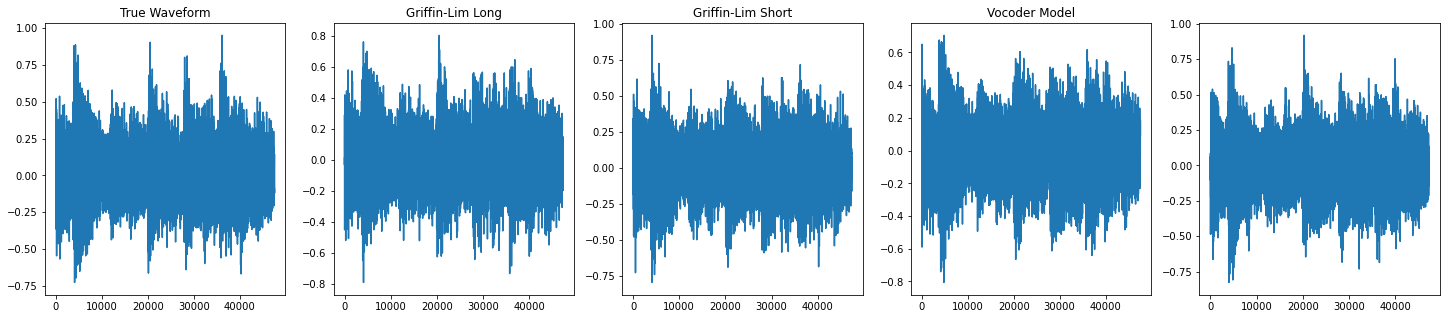

In [102]:
fig, axes = plt.subplots(nrows=x.shape[0], ncols=5, figsize=(25,5*x.shape[0]))

for i in range(x.shape[0]):
    axes[0].set_title('True Waveform')
    axes[0].plot(x[i].flatten().detach().cpu().numpy())
    axes[1].set_title('Griffin-Lim Long')
    axes[1].plot(inverse_mel_griffinlim_x[i].flatten().detach().cpu().numpy())
    axes[2].set_title('Griffin-Lim Short')
    axes[2].plot(inverse_mel_short_griffinlim_x[i].flatten().detach().cpu().numpy())
    axes[3].set_title('Vocoder Model')
    axes[3].plot(vocoder_x[i].flatten().detach().cpu().numpy())
    axes[4].plot(griffinlim_x[i].flatten().detach().cpu().numpy())

In [103]:
for i in range(x.shape[0]):
    print(f'Sample {i}')
    display(Audio(x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(inverse_mel_griffinlim_x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(inverse_mel_short_griffinlim_x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(vocoder_x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(griffinlim_x[i,0].detach().cpu().numpy(), rate=16000))

Sample 0


In [104]:
i = 7
torchaudio.save(f'/home/code-base/scratch_space/gl_vocoder_comparison/sample_{i}_mucoder.wav', vocoder_x[0].detach().cpu(), 16000)
torchaudio.save(f'/home/code-base/scratch_space/gl_vocoder_comparison/sample_{i}_gl.wav', griffinlim_x[0].detach().cpu(), 16000)
torchaudio.save(f'/home/code-base/scratch_space/gl_vocoder_comparison/sample_{i}_melspec_gl.wav', inverse_mel_griffinlim_x[0].detach().cpu(), 16000)
torchaudio.save(f'/home/code-base/scratch_space/gl_vocoder_comparison/sample_{i}_melspec_gl_short.wav', inverse_mel_short_griffinlim_x[0].detach().cpu(), 16000)
torchaudio.save(f'/home/code-base/scratch_space/gl_vocoder_comparison/sample_{i}_ground_truth.wav', x[0].detach().cpu(), 16000)

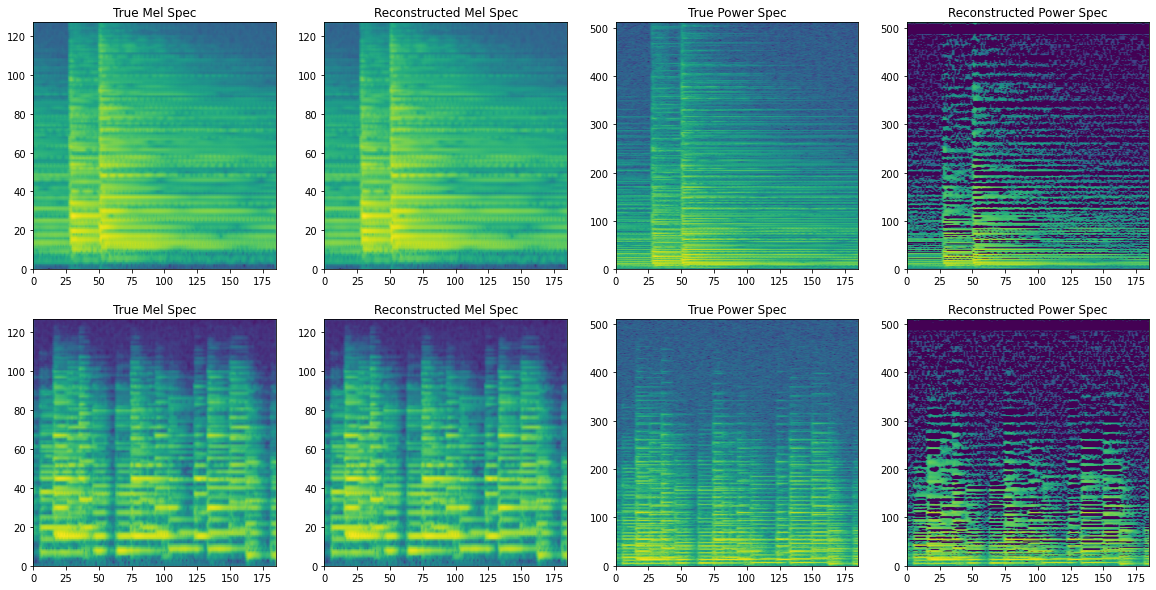

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i in range(2):
    axes[i,0].set_title('True Mel Spec')
    axes[i,0].pcolormesh(melspec_x[i, 0].log2().detach().cpu().numpy(), shading='gouraud')
    
    axes[i,1].set_title('Reconstructed Mel Spec')
    axes[i,1].pcolormesh(melspec_x_hat[i, 0].log2().detach().cpu().numpy(), shading='gouraud')
    
    axes[i,2].set_title('True Power Spec')
    axes[i,2].pcolormesh(powerspec_x[i, 0].log2().detach().cpu().numpy(), shading='gouraud')
    
    axes[i,3].set_title('Reconstructed Power Spec')
    axes[i,3].pcolormesh((powerspec_x_hat[i, 0] + 1e-8).log2().detach().cpu().numpy(), shading='gouraud')

In [66]:
griffinlim_reconstructed_power_x = griffinlim_transform(powerspec_x_hat)
griffinlim_true_power_x = griffinlim_transform(powerspec_x)
with torch.no_grad():
    vocoder_x = generate(vocoder_model_params, vocoder_model, melspec_x.log2(), t_start=49, t_end=0, init_x=torch.randn_like(x))

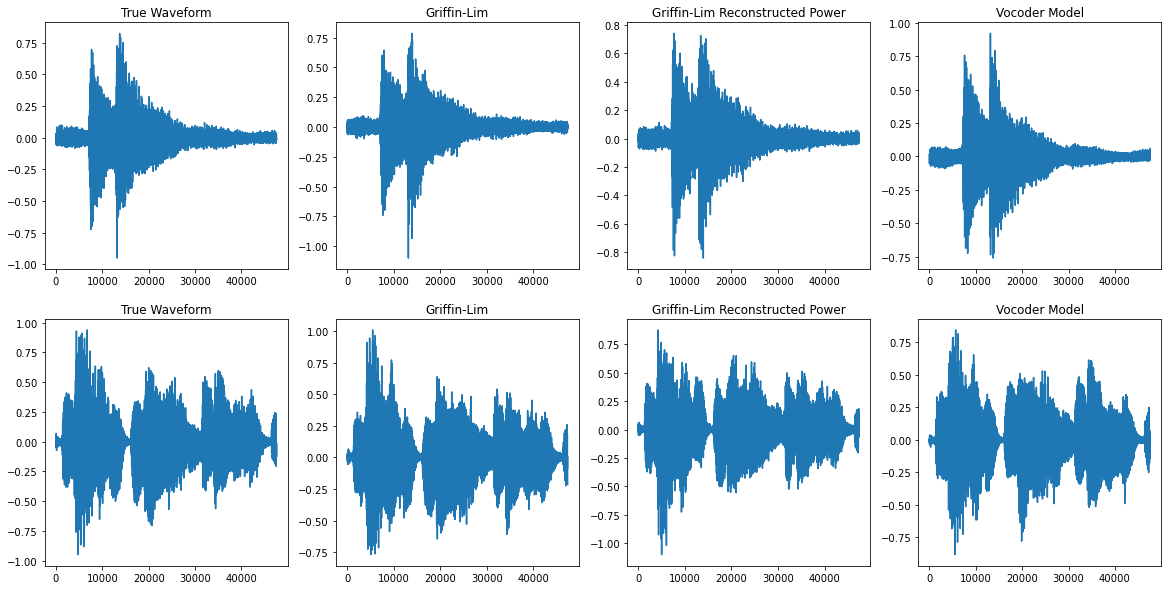

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

for i in range(x.shape[0]):
    axes[i,0].set_title('True Waveform')
    axes[i,0].plot(x[i].flatten().detach().cpu().numpy())
    axes[i,1].set_title('Griffin-Lim')
    axes[i,1].plot(griffinlim_true_power_x[i].flatten().detach().cpu().numpy())
    axes[i,2].set_title('Griffin-Lim Reconstructed Power')
    axes[i,2].plot(griffinlim_reconstructed_power_x[i].flatten().detach().cpu().numpy())
    axes[i,3].set_title('Vocoder Model')
    axes[i,3].plot(vocoder_x[i].flatten().detach().cpu().numpy())

In [72]:
for i in range(x.shape[0]):
    display(Audio(x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(griffinlim_true_power_x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(griffinlim_reconstructed_power_x[i,0].detach().cpu().numpy(), rate=16000))
    display(Audio(vocoder_x[i,0].detach().cpu().numpy(), rate=16000))